<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/6Sates_clusteringCountyData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=c826bc327919b1d9557994f5079d0e6542a69831daa37c68804d43094d3f6fc8
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [3]:
import pandas as pd
import wget 
from PIL import Image

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load USA State Fips Code

In [4]:
state_fips_code = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/US_State_FIPSCodes.csv',low_memory=False)
state_fips_code.head()

,State,Postal Code,STFIPS
0,Alabama,AL,1
1,Alaska,AK,2
2,Arizona,AZ,4
3,Arkansas,AR,5
4,California,CA,6


# Load Social Distancing Inertia Data [Maryland University]

In [5]:
maryland_sd_inertia = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/Maryland_Inertia_Data/County_Oct13.csv',low_memory=False)
maryland_sd_inertia.head()

,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
0,1001,Autauga County,1,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,1/1/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
1,1001,Autauga County,1,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,1/2/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
2,1001,Autauga County,1,15,15,3.18,42.2,1.0,40.3,0.62,2.57,0,55601,-0.4,1/3/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
3,1001,Autauga County,1,33,20,2.85,43.9,1.2,29.5,0.33,2.52,0,55601,-2.3,1/4/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
4,1001,Autauga County,1,40,22,2.56,42.8,1.2,30.9,0.23,2.33,0,55601,-9.7,1/5/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0


In [6]:
maryland_sd_inertia['STFIPS'].unique()

array([ 1,  2,  4,  5,  6,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56])

## Fixdate column of Social Distancing inertia

In [7]:
def fixDate(x, appendTwenty):
  arr = x.split('/')
  m = arr[0]
  d = arr[1]
  y = arr[2]

  if int(m) < 10:
    m = '0'+str(m)
  if int(d) < 10:
    d = '0'+str(d)
  if appendTwenty == True:
    return '20'+y+'-'+m+'-'+d
  else:
      return y+'-'+m+'-'+d

In [8]:
maryland_sd_inertia['date'] = maryland_sd_inertia['date'].apply(lambda x: fixDate(x,False))
maryland_sd_inertia.reset_index(drop=True)

,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
0,1001,Autauga County,1,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,2020-01-01,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
1,1001,Autauga County,1,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,2020-01-02,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
2,1001,Autauga County,1,15,15,3.18,42.2,1.0,40.3,0.62,2.57,0,55601,-0.4,2020-01-03,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
3,1001,Autauga County,1,33,20,2.85,43.9,1.2,29.5,0.33,2.52,0,55601,-2.3,2020-01-04,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
4,1001,Autauga County,1,40,22,2.56,42.8,1.2,30.9,0.23,2.33,0,55601,-9.7,2020-01-05,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901749,56045,Weston County,56,40,20,3.00,27.4,10.3,172.4,0.04,2.96,3,6967,-16.3,2020-10-09,8.34,30,52867,0.5,1.5,53.07,3,1,153,3.76,0.50,0.017,0.3828,5.50,0,38.319241,6.6,191.28,1.32,3,29,9.69,0,1.2,9.3,18.5,1.51,0.96
901750,56045,Weston County,56,37,22,3.37,26.1,10.3,90.4,0.11,3.26,4,6967,-7.8,2020-10-10,8.34,30,52867,0.5,1.5,53.07,3,1,153,3.76,0.50,0.017,0.3828,5.65,0,38.321286,6.7,191.49,1.33,3,29,9.69,0,1.2,9.3,18.5,1.51,0.96
901751,56045,Weston County,56,42,26,2.70,24.5,13.1,71.9,0.06,2.64,0,6967,-25.3,2020-10-11,8.34,30,52867,0.5,1.5,53.07,3,1,153,3.76,0.50,0.017,0.3349,5.81,0,38.323483,6.9,191.76,1.33,3,25,9.69,0,1.2,9.3,18.5,1.51,0.96
901752,56045,Weston County,56,26,19,3.05,25.3,9.9,102.7,0.04,3.00,0,6967,-15.2,2020-10-12,8.34,30,52867,0.5,1.5,53.07,3,1,153,3.76,0.50,0.017,0.1914,6.08,0,38.324928,7.0,192.09,1.33,3,24,9.69,0,1.2,9.3,18.5,1.51,0.96


In [9]:
maryland_sd_inertia.head(3)

,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
0,1001,Autauga County,1,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,2020-01-01,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
1,1001,Autauga County,1,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,2020-01-02,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
2,1001,Autauga County,1,15,15,3.18,42.2,1.0,40.3,0.62,2.57,0,55601,-0.4,2020-01-03,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0


In [10]:
maryland_sd_inertia.columns

Index(['CTFIPS', 'CTNAME', 'STFIPS', 'Social distancing index',
       '% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person', 'New COVID cases', 'Population',
       '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people', 'New cases/1000 people',
       'Active cases/1000 people', '#days: decreasing COVID cases',
       '% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Imported COVID cases', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 people',
       'Unemploy

## Assign State Name

California, New York, Texas, Iowa, Wisconsin, Colorado

In [11]:
maryland_sd_inertia = pd.merge(state_fips_code,maryland_sd_inertia,how='inner',left_on=['STFIPS'],right_on=['STFIPS'])
print(maryland_sd_inertia.shape)

maryland_sd_inertia.head(2)

(901467, 45)


,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
0,Alabama,AL,1,1001,Autauga County,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,2020-01-01,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
1,Alabama,AL,1,1001,Autauga County,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,2020-01-02,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0


In [12]:
## not using this
def assignStateName(x):
  if x == 6:
    return 'California' # 6
  elif x == 36:
    return 'New York' # 36
  elif x == 48:
    return 'Texas' #1
  elif x == 19:
    return 'Iowa' #19
  elif x == 8:
    return 'Colorado' #8
  elif x == 55:
    return 'Wisconsin' #31
  else:
    return 'NA'

## Filter Data for 6 States

In [13]:
state_list = ['California', 'New York', 'Texas', 'Iowa', 'Wisconsin', 'Colorado']

maryland_sd_inertia_6states = maryland_sd_inertia[maryland_sd_inertia['State'].isin(state_list)]
print(maryland_sd_inertia_6states.head(3) )

            State Postal Code  ...  Cumulative inflation rate  COVID death rate
53382  California          CA  ...                        0.3               0.0
53383  California          CA  ...                        0.3               0.0
53384  California          CA  ...                        0.3               0.0

[3 rows x 45 columns]


In [14]:
maryland_sd_inertia_6states.State.unique()

array(['California', 'Colorado', 'Iowa', 'New York', 'Texas', 'Wisconsin'],
      dtype=object)

## Multiclass Classification without a Classifier!

In [15]:
maryland_sd_inertia_6states.columns

Index(['State', 'Postal Code', 'STFIPS', 'CTFIPS', 'CTNAME',
       'Social distancing index', '% staying home', 'Trips/person',
       '% out-of-county trips', '% out-of-state trips', 'Miles/person',
       'Work trips/person', 'Non-work trips/person', 'New COVID cases',
       'Population', '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people', 'New cases/1000 people',
       'Active cases/1000 people', '#days: decreasing COVID cases',
       '% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Imported COVID cases', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 p

In [16]:
X_cols = ['Social distancing index','% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person','% change in consumption','Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people','% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Imported COVID cases', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation rate']

Y_col = ['New cases/1000 people']


In [32]:
# have to check which values are NA
maryland_sd_inertia_6states_filtered = maryland_sd_inertia_6states.dropna()

In [33]:
n_classes = 3
training_inputs = maryland_sd_inertia_6states_filtered[X_cols].values
#training_outputs_labels = [c for row in maryland_sd_inertia_6states[Y_col].values for c in row]


# K-means clustering

In [43]:
from sklearn.cluster import KMeans


y_kmeans = KMeans(n_clusters=5,init ='k-means++', max_iter=300, n_init=10,random_state=0 ).fit_predict(training_inputs)

X = training_inputs

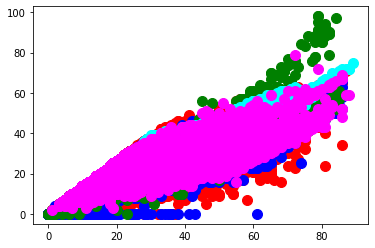

In [44]:
#6 Visualising the clusters
plt.scatter(X[y_kmeans==0, 0], X[y_kmeans==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X[y_kmeans==1, 0], X[y_kmeans==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(X[y_kmeans==2, 0], X[y_kmeans==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(X[y_kmeans==3, 0], X[y_kmeans==3, 1], s=100, c='cyan', label ='Cluster 4')
plt.scatter(X[y_kmeans==4, 0], X[y_kmeans==4, 1], s=100, c='magenta', label ='Cluster 5')

In [40]:
y_kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

# unused

In [18]:
clusters = {this_class:[training_inputs[i] for i,c in enumerate(training_outputs_labels) if c == this_class] for this_class in range(n_classes)}
centroids = [np.mean(np.array(vectors), axis=0) for vectors in clusters.values()]

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
centroids[0]


array([ 2.61830086e+01,  2.14872050e+01,  3.39262520e+00,  3.76326256e+01,
        5.18143702e+00,  4.79609003e+01,  5.13017068e-01,  2.87962860e+00,
       -1.71232106e-01,  1.25645389e+00,  2.60582061e+01,  5.30726043e+04,
        3.50244410e+00,  2.22300677e+01,  5.08480795e+01,  3.02109159e+02,
        1.31224003e+02,  1.43372325e+02,  2.84950819e+00,  2.70620362e-01,
                   nan,  4.75387850e+01,  9.04882223e+00,  3.01258867e+01,
        3.90624826e+00,  1.83408998e+02,  3.43332575e+01,  2.22307452e+00,
        4.52825801e+01,  3.28306483e+00,  6.73991119e+00,  1.85073802e+01,
        2.28624264e-01])

In [20]:
def plot_class_centroid(c):
  class_vectors = list(clusters.values())[c]
  class_label_vector = centroids[c]
  
  X = [x for x,_ in class_vectors + [class_label_vector]]
  Y = [y for _,y in class_vectors + [class_label_vector]]
  colours = ([c] * (len(X) - 1)) + [c+1]
  sizes = ([10] * (len(X) - 1)) + [len(X)]

  plt.scatter(X, Y, s = sizes, c= colours, alpha=0.5)

In [21]:
class_vectors = list(clusters.values())[0]
class_label_vector = centroids[0]
#print(class_label_vector)
#print(class_vectors)
#X = [x for x,_ in class_vectors + [class_label_vector]]


In [22]:
from scipy.spatial.distance import cosine

def predict_class(vector, class_vectors):
  scores = [(cosine(vector, class_vector),c) for c,class_vector in enumerate(class_vectors)]
  ranked = [c for _,c in sorted(scores)]
  return ranked[0]

In [23]:
maryland_sd_inertia_6states[X_cols].values[0]

array([ 5.0000e+01,  3.2000e+01,  2.4100e+00,  2.6100e+01,  4.0000e-01,
        3.8000e+01,  2.0000e-01,  2.2100e+00, -2.1700e+01,  1.5040e+01,
        1.9000e+01,  9.2574e+04,  1.0500e+01,  2.2500e+01,  4.9110e+01,
        2.0020e+03,  1.1550e+03,  1.3100e+02,  2.0500e+00,  2.2000e-01,
               nan,  5.4000e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  9.0000e-01,
        3.9000e+00,  5.7000e+00,  3.0000e-01])

In [24]:
predict_class(maryland_sd_inertia_6states[X_cols].values[299], centroids)

0

## Evaluate metrics

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(y,y_hat,labels):
  print(classification_report(y,y_hat))
  cm = confusion_matrix(y,y_hat)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmat = pd.DataFrame(cm)
  cmat.columns = labels
  #cmat.set_index([pd.Index(labels, '')],inplace=True)
  sns.heatmap(cmat,cmap="YlGnBu", annot=True)
  plt.title("Confusion Matrix")

In [26]:
training_outputs_labels = [c for row in maryland_sd_inertia_6states[Y_col].values for c in row]
labels = set(training_outputs_labels)
labels

{0.0,
 0.2744,
 0.125,
 0.1875,
 0.25,
 0.0625,
 0.3125,
 0.6875,
 0.375,
 1.25,
 2.0518,
 2.4345,
 0.3156,
 4.9803,
 0.5,
 0.4375,
 0.4109,
 0.1906,
 0.2531,
 0.2859,
 0.3812,
 0.5687,
 0.3843,
 0.7593,
 0.9468,
 0.6343,
 0.5124,
 0.703,
 0.6405,
 0.7655,
 0.828,
 0.7061,
 0.5186,
 0.7686,
 0.0244,
 0.1494,
 0.2119,
 0.0869,
 0.7809999999999999,
 1.406,
 0.1113,
 1.0997,
 0.0488,
 0.2988,
 0.4482,
 0.1357,
 0.1982,
 0.3857,
 0.3232,
 0.1738,
 0.3613,
 0.4238,
 0.2607,
 0.0107,
 0.0732,
 1.3119999999999998,
 1.8119999999999998,
 3.3745,
 0.1601,
 0.2226,
 0.0351,
 0.0976,
 0.4101,
 0.7226,
 0.3476,
 0.122,
 0.1845,
 0.0595,
 0.3964,
 0.5351,
 0.5458,
 0.6708,
 0.0214,
 0.0839,
 0.1464,
 0.2089,
 0.4667,
 0.7792,
 0.1083,
 0.0458,
 0.2577,
 0.3202,
 0.2333,
 0.3583,
 0.1708,
 0.2958,
 0.4208,
 0.3827,
 0.4833,
 0.0702,
 0.0077,
 0.2196,
 0.1571,
 0.1952,
 0.1327,
 0.0321,
 0.0946,
 0.3065,
 1.1678,
 0.244,
 0.369,
 0.4696,
 0.4071,
 0.3446,
 1.5321,
 0.4315,
 0.5077,
 1.0458,
 0.0565,
 

In [27]:
centroid_predictions_labels = [predict_class(xy, centroids) for xy in maryland_sd_inertia_6states[X_cols].values]
print(centroid_predictions_labels)
print(training_outputs_labels)
evaluate(training_outputs_labels, centroid_predictions_labels, labels)



[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

ValueError: ignored

In [ ]:
def one_hot(i, vec_len):
  vector = [0]*vec_len
  vector[i] = 1
  return vector

def format_prediction(predicted_outputs):
  predicted_image_array = np.zeros_like(image_array)
  i = 1
  for row,pixels in enumerate(predicted_image_array):
    for column in range(len(pixels)):
      #print(i)
      #if i >= y: print('breaking ',i); break

      p = np.argmax(predicted_outputs[i-1])
      predicted_image_array[row][column] = [WHITE,RED,BLUE][p]
      i += 1
    #break
  return predicted_image_array

In [ ]:
RED = [255,0,0]
WHITE = [255,255,255]
BLUE = [0,0,255]

x,y = maryland_sd_inertia_6states.shape
z = 3 # number of classes 
x,y,z

In [ ]:
image_array = np.zeros((x,y,z), np.uint8)


In [ ]:
plot_class_centroid(0)
centroids[0]

In [ ]:

centroid_predictions = [one_hot(p, z) for p in centroid_predictions_labels]
#Image.fromarray(format_prediction(centroid_predictions)) 
centroid_predictions